# Integrating the Deep Image Prior on multiple images with the VAE for generating input tensors.

## The idea is that we have some mapping between images and their corresponding latent spaces, which serve as input to the deep image prior.

VAE doesn't need to be perfect at all, just need some logic in place to generate distributions for the "random" input tensors so that we can extend the deep image prior framework to multiple images at a time, and new images

Gets the entire repository in the current Session

In [60]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""

!git clone https://github.com/petersim1/deep-image-prior
!mv deep-image-prior/* ./

fatal: destination path 'deep-image-prior' already exists and is not an empty directory.
mv: cannot stat 'deep-image-prior/*': No such file or directory


Gets my gdrive into the current session (need this for reading of trained VAE parameters)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
gdrive_path = 'drive/MyDrive/DS-GA-3001/'
vae_modeldict_path = gdrive_path+'VAE_Trained.pth'

In [62]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

from project_extension.VAE import VAE #reads the VAE network

import torch
import torch.optim
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import DatasetFolder,ImageFolder

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/100.

load VAE model
 - network architecture stored in repo
 - network trained parameters stored locally (or on gdrive)

In [63]:
# load VAE model
# network architecture stored in repo
# network trained parameters stored locally (or on gdrive)
VAE_Model = VAE()
vae_state_dict = torch.load(vae_modeldict_path)
VAE_Model.load_state_dict(vae_state_dict)

<All keys matched successfully>

In [64]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# Custom DataLoader on images stored locally (or in our case, stored in repository). Not many images, so this is reasonable.

In [65]:
transform_size = transforms.Compose([
    transforms.ToTensor()
])

loader = ImageFolder('project_extension/vae_train_data',transform_size)

num_images_train = 3

inds = np.arange(len(loader))
np.random.shuffle(inds)

train_inds,test_inds = inds[num_images_train:],inds[:num_images_train]


train_sampler = SubsetRandomSampler(train_inds)
test_sampler  = SubsetRandomSampler(test_inds)

train_loader = DataLoader(dataset=loader,
                          batch_size=num_images_train,
                          sampler=train_sampler)

test_loader = DataLoader(dataset=loader,
                          batch_size=1,
                          sampler=test_sampler)

## Define a function to replace the "get_noise()" function defined in the original repository. This will use mu and sigma values output from the VAE.

VAE returns latent space sufficient statistics in the form of a vector (1x512). So we need to resample this 512 times (width) and however many times for the depth of the input (they use 32 in the paper, we can make it whatever we'd like).

In [66]:
def gen_random_input(mu,sigma,width,depth) :
  '''
  This only reads an image at a time.
  '''
  batch_size = mu.size(0)
  out = torch.zeros((batch_size,depth,mu.size(-1),width))
  for i in range(width) :
    for j in range(depth) :
      out[:,j,:,i] = torch.normal(mu,sigma)
  return out

In [67]:
def gen_fixed_input(mu,sigma,width,depth) :
  '''
  This only reads an image at a time.
  '''
  col = torch.normal(mu,sigma)
  out = col.unsqueeze(2).repeat(1, 1, width)
  out = out.unsqueeze(1).repeat(1, depth, 1, 1)

  #--BRUTE FORCE METHOD--
  #batch_size = mu.size(0)
  #out = torch.zeros((batch_size,depth,mu.size(-1),width))
  #col = torch.normal(mu,sigma)
  #for i in range(width) :
  #  for j in range(depth) :
  #    out[:,j,:,i] = col

  return out

# View random set of images stored in our repository.

These will be the images the network is training on.

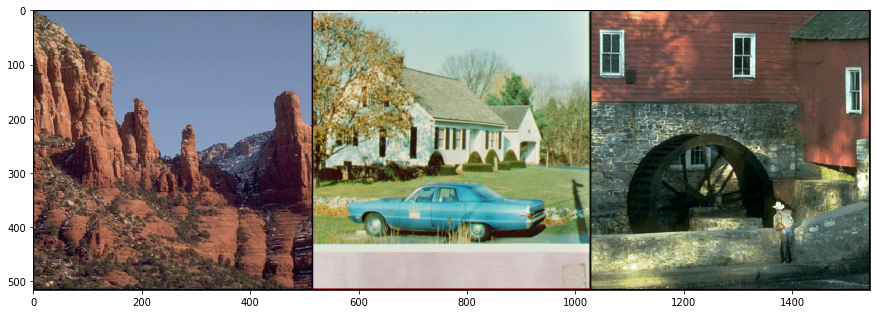

In [76]:
img,_ = next(iter(train_loader))
grid_img = torchvision.utils.make_grid(img, nrow=num_images_train)

plt.figure(figsize=(15,6))
plt.imshow(grid_img.permute(1, 2, 0))

# Will need to update some functions previously defined to account for 
 - batches (multiple images)
 - new noise generation

In [77]:
def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.
    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        tot_loss = []
        for j in range(100):
            optimizer.zero_grad()
            loss = closure()
            tot_loss.append(loss.item())
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        tot_loss = []
        for j in range(num_iter):
            optimizer.zero_grad()
            loss = closure()
            tot_loss.append(loss.item())
            optimizer.step()
    else:
        assert False

    return tot_loss

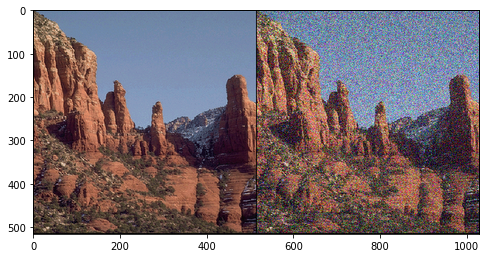

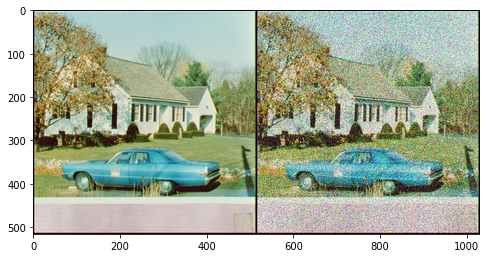

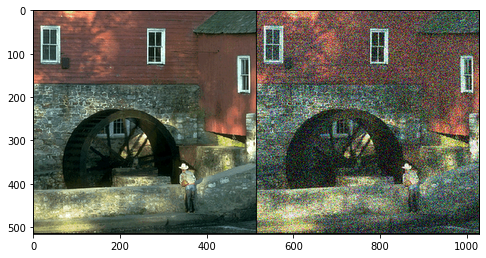

In [78]:
img_nps, img_noisy_nps = [],[]

for im in img :
    img_np = im.numpy()
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);

    img_nps.append(img_np)
    img_noisy_nps.append(img_noisy_np)

In [79]:
INPUT = 'noise' # 'meshgrid'
noise_type = 'u'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
GENERATE_RANDOM_INPUT = True

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 3000
input_depth = 5
width = 512
figsize = 10


net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)


img_out,mu,logvar = VAE_Model(img)

# New Custom function to generate "random" inputs.
if GENERATE_RANDOM_INPUT:
  net_inputs = gen_random_input(mu,logvar.mul(0.5).exp_(),width,input_depth).type(dtype).detach()
else:
  net_inputs = gen_fixed_input(mu,logvar.mul(0.5).exp_(),width,input_depth).type(dtype).detach()


# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

# Convert noisy images to tensors. In minibatch format. These are "target" images.
img_noisy_torches = torch.from_numpy(np.array(img_noisy_nps)).type(dtype)


Number of params: 2186619


Starting optimization with ADAM


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_

Iteration 00000    Loss 0.103647   PSNR_noisy: 9.367180   PSRN_gt: 10.771560 PSNR_gt_sm: 10.771560


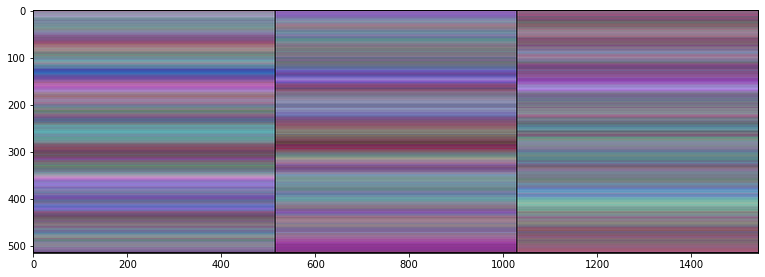

Iteration 00100    Loss 0.068888   PSNR_noisy: 10.409123   PSRN_gt: 12.663917 PSNR_gt_sm: 12.468274


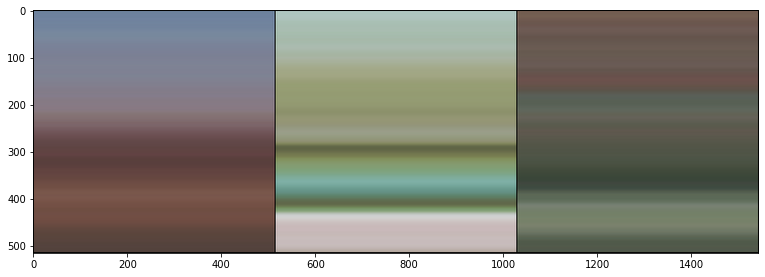

Iteration 00200    Loss 0.068765   PSNR_noisy: 10.404236   PSRN_gt: 12.659776 PSNR_gt_sm: 12.677802


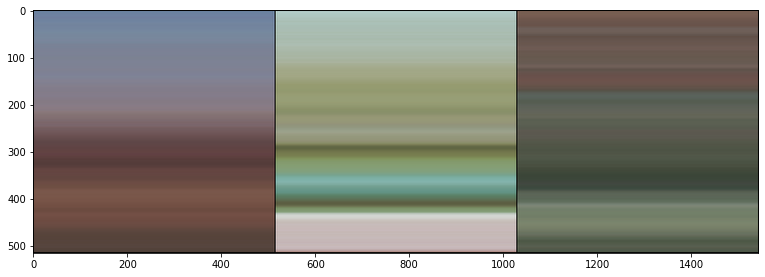

Iteration 00300    Loss 0.068652   PSNR_noisy: 10.415130   PSRN_gt: 12.670986 PSNR_gt_sm: 12.682495


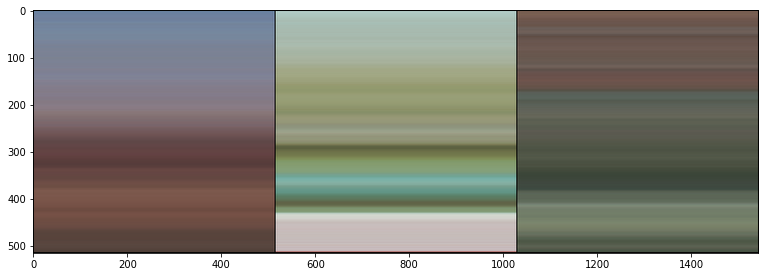

Iteration 00400    Loss 0.068590   PSNR_noisy: 10.418642   PSRN_gt: 12.676900 PSNR_gt_sm: 12.673043


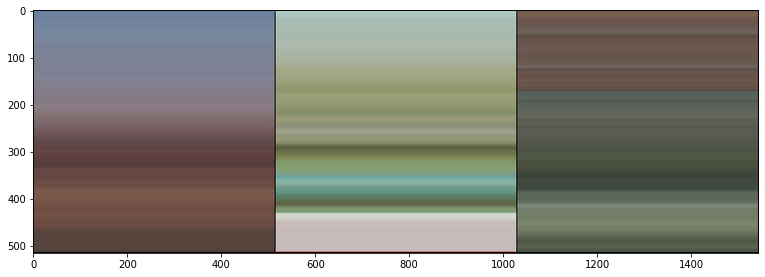

Iteration 00500    Loss 0.068598   PSNR_noisy: 10.363574   PSRN_gt: 12.590190 PSNR_gt_sm: 12.667246


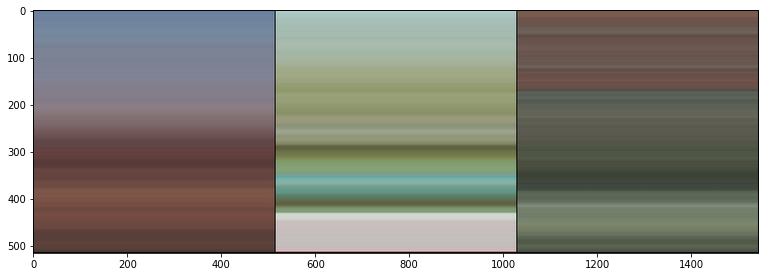

Iteration 00600    Loss 0.068581   PSNR_noisy: 10.415714   PSRN_gt: 12.664999 PSNR_gt_sm: 12.665637


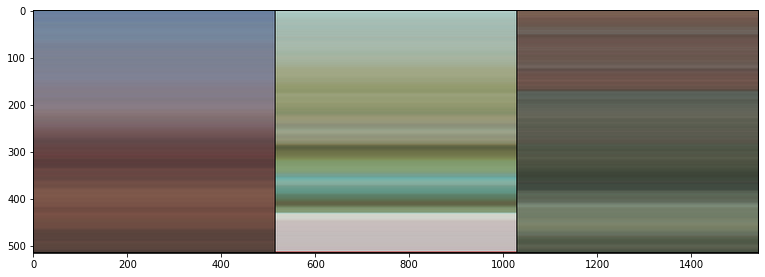

Iteration 00700    Loss 0.068600   PSNR_noisy: 10.393649   PSRN_gt: 12.625145 PSNR_gt_sm: 12.664222


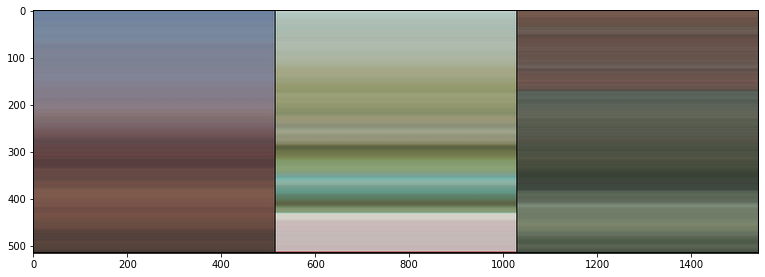

Iteration 00800    Loss 0.068539   PSNR_noisy: 10.398388   PSRN_gt: 12.645961 PSNR_gt_sm: 12.663883


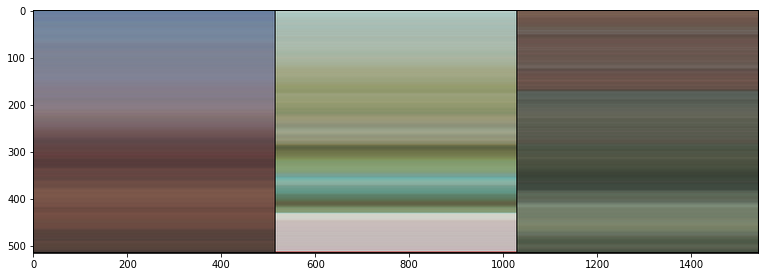

Iteration 00900    Loss 0.068543   PSNR_noisy: 10.401482   PSRN_gt: 12.647736 PSNR_gt_sm: 12.663572


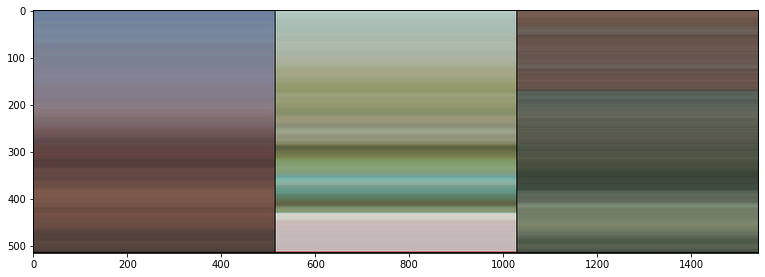

In [ ]:
net_input_saved = net_inputs.detach().clone()
noise = net_inputs.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_inputs)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torches)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    #print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm),end='\n')
    if  PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm),end='\n')
        out_np = out.detach().cpu().numpy()
        #plot_image_grid([np.clip(out_np, 0, 1), 
        #                 np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        plot_image_grid([*np.clip(out_np, 0, 1)], factor=figsize, nrow=num_images_train)

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_inputs)
losses = optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
int_outputs = net(net_inputs)
out_np = int_outputs.detach().cpu().numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


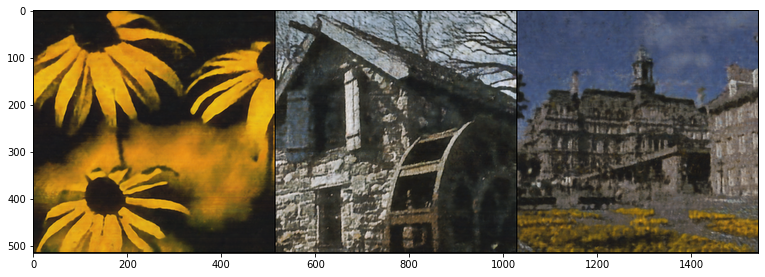

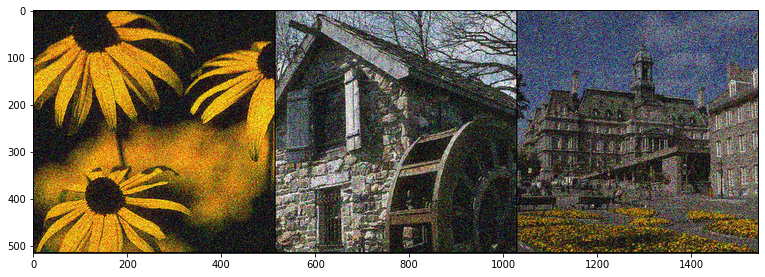

In [ ]:
_ = plot_image_grid([*np.clip(out_np, 0, 1)], factor=10, nrow=num_images_train)
_ = plot_image_grid(img_noisy_nps, factor=10, nrow=3)

In [ ]:
if GENERATE_RANDOM_INPUT:
  new_net_inputs = gen_random_input(mu,logvar.mul(0.5).exp_(),width,input_depth).type(dtype).detach()
else:
  new_net_inputs = gen_fixed_input(mu,logvar.mul(0.5).exp_(),width,input_depth).type(dtype).detach()

new_int_outputs = net(new_net_inputs)
new_out_np = new_int_outputs.detach().cpu().numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


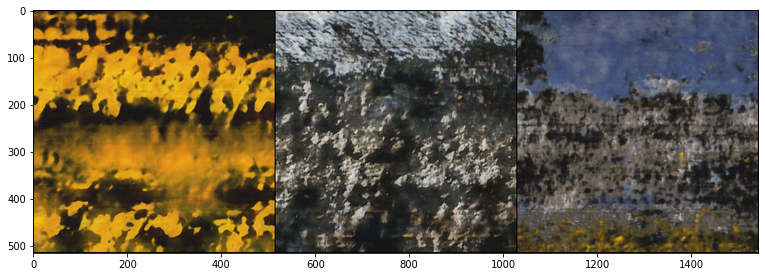

In [ ]:
_ = plot_image_grid([*np.clip(new_out_np, 0, 1)], factor=10, nrow=num_images_train)